In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam
from torch.nn import SmoothL1Loss, HuberLoss  # Huber
from sklearn.model_selection import train_test_split
from utils.pcd_loader import PCDBiomassDatasetTorch, collate_points_with_mask
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from typing import Tuple

In [9]:
image_dir = "report/images/"
SEED = 30
rng = np.random.default_rng(SEED)
torch.manual_seed(SEED)

root = "data"
train_labels = root + "/train_list.txt"
test_labels = root + "/test_list.txt"

train_data = PCDBiomassDatasetTorch(root=root, labels_txt=train_labels,
                                    strict_exists=False, cache_points=True)
train_indices = np.arange(len(train_data))
train_idx, val_idx = train_test_split(train_indices, test_size=0.2, random_state=SEED, shuffle=True)

train_loader = DataLoader(Subset(train_data, train_idx),
                          batch_size=8, shuffle=True, num_workers=0,
                          pin_memory=True, collate_fn=collate_points_with_mask)

val_loader = DataLoader(Subset(train_data, val_idx),
                        batch_size=8, shuffle=False, num_workers=0,
                        pin_memory=True, collate_fn=collate_points_with_mask)

test_loader = DataLoader(
    PCDBiomassDatasetTorch(root=root, labels_txt=test_labels,
                           strict_exists=False, cache_points=True),
    batch_size=8, shuffle=False, num_workers=0,
    pin_memory=True, collate_fn=collate_points_with_mask
)

In [10]:
for (points, mask), y in train_loader:
    print(points.shape, mask.shape, y.shape)
    break  # только первый батч

torch.Size([8, 45184, 3]) torch.Size([8, 45184]) torch.Size([8])


In [11]:
for (points, mask), y in test_loader:
    print(points.shape, mask.shape, y.shape)
    break  # только первый батч

torch.Size([8, 43512, 3]) torch.Size([8, 43512]) torch.Size([8])


In [12]:
len(train_loader), len(val_loader), len(test_loader)

(21, 6, 13)

min/25%/50%/75%/max: 18035.0 26094.5 31217.5 40655.5 55445.0
Медианное количество точек: 31217


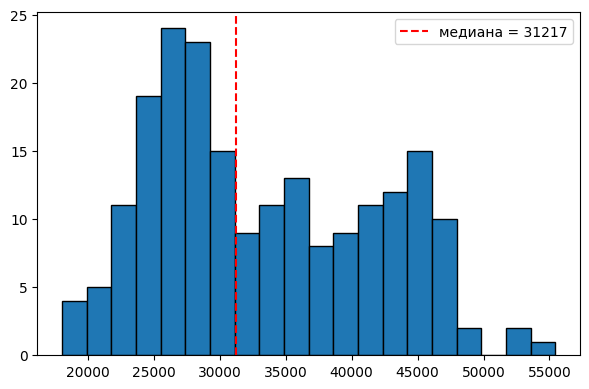

In [13]:
# sizes
sizes = np.array([len(pts) for pts, _, _ in train_data.iter()], dtype=int)
print("min/25%/50%/75%/max:",
      np.floor(np.min(sizes)), *np.percentile(sizes, [25, 50, 75]), np.ceil(np.max(sizes)))
N = int(np.percentile(sizes, 50))
print("Медианное количество точек:", N)

plt.figure(figsize=(6, 4))
plt.hist(sizes, bins=20, edgecolor='black')
plt.axvline(N, color='red', linestyle='--', label=f'медиана = {N}')
plt.legend()
plt.tight_layout()
plt.savefig(image_dir+"distr_sizes.png")
plt.show()

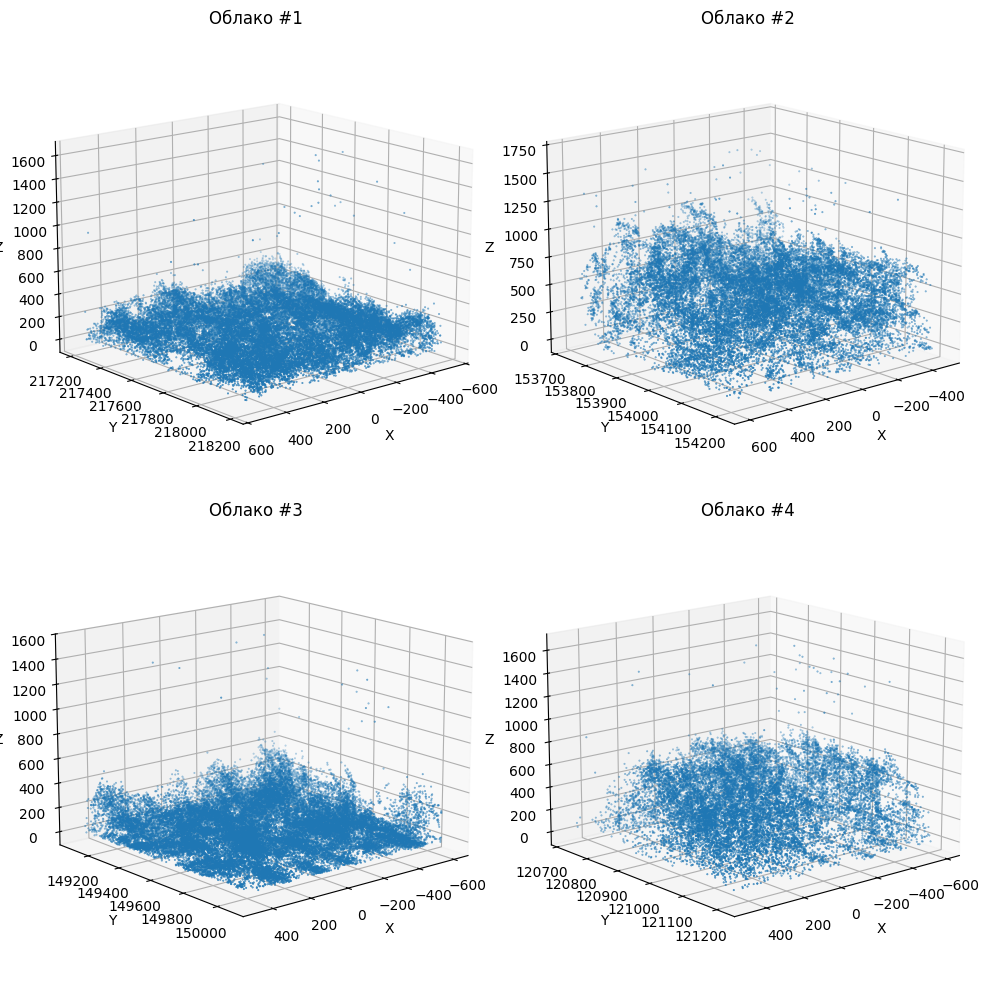

In [14]:
# несколько облаков
fig = plt.figure(figsize=(10, 10))
for i in range(4):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    pts, _, _ = train_data[np.random.randint(0, len(train_data))]
    if len(pts) > 0:
        ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=0.2)
    ax.set_title(f'Облако #{i + 1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=15, azim=50)
plt.tight_layout()
plt.savefig(image_dir+"examples_clouds.png")
plt.show()

In [15]:
class HuberRel(nn.Module):
    def __init__(self, delta=1.0, alpha=0.1, eps=1e-6):
        super().__init__()
        self.huber = nn.SmoothL1Loss(beta=delta, reduction='mean')  # Huber
        self.alpha = alpha
        self.eps = eps

    def forward(self, y_pred, y_true):
        l_h = self.huber(y_pred, y_true)
        rel = torch.abs(y_pred - y_true) / (torch.abs(y_true) + self.eps)
        return l_h + self.alpha * rel.mean()

In [16]:
class PointNetMasked(nn.Module):
    def __init__(self, in_channels=3, dropout=0.2):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=1, bias=False),
            nn.BatchNorm1d(64), nn.ReLU(inplace=True),
            nn.Conv1d(64, 128, kernel_size=1, bias=False),
            nn.BatchNorm1d(128), nn.ReLU(inplace=True),
            nn.Conv1d(128, 256, kernel_size=1, bias=False),
            nn.BatchNorm1d(256), nn.ReLU(inplace=True),
            # nn.Conv1d(256, 512, kernel_size=1, bias=False),
            
        )
        self.head = nn.Sequential(
            nn.Linear(512, 256), nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, 128), nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    @staticmethod
    def masked_maxpool(x, mask):
        # x: (B, C, T), mask: (B, T)
        mask_f = mask[:, None, :].to(dtype=x.dtype)  # (B,1,T)
        x_masked = x.masked_fill(mask_f <= 0, -1e9)
        return torch.amax(x_masked, dim=2)  # (B, C)

    @staticmethod
    def masked_avgpool(x, mask):
        # x: (B, C, T), mask: (B, T)
        mask_f = mask[:, None, :].to(dtype=x.dtype)  # (B,1,T)
        x_sum = torch.sum(x * mask_f, dim=2)  # (B, C)
        cnt = torch.sum(mask_f, dim=2) + 1e-6  # (B, 1)
        return x_sum / cnt

    def forward(self, inputs: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        points, mask = inputs  # points: (B, T, 3), mask: (B, T)
        x = points.transpose(1, 2)  # → (B, 3, T)
        h = self.mlp(x)  # (B, 256, T)
        g1 = self.masked_maxpool(h, mask)
        g2 = self.masked_avgpool(h, mask)
        g = torch.cat([g1, g2], dim=1)  # (B, 512)
        out = self.head(g)  # (B, 1)
        return out.squeeze(1)  # (B,)

In [17]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, verbose=True, save_path="best_model_2.pt"):
        """
        patience:   сколько эпох ждать без улучшений
        min_delta:  минимальное изменение метрики, чтобы считать улучшением
        save_path:  куда сохранять лучшую модель
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.save_path = "checkpoints/" + save_path
        self.best_score = None
        self.counter = 0
        self.should_stop = False

    def __call__(self, val_metric, model):
        score = -val_metric  # потому что val_loss → меньше = лучше
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"  No improvement ({self.counter}/{self.patience})")
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.save_path)
        if self.verbose:
            print(f"  ✅ Saved new best model to {self.save_path}")

In [18]:
def run(loader, optimizer, criterion, train: bool):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).train(train)
    total_loss = total_mse = total_mae = n = 0.0
    for (points, mask), y in loader:
        points = points.to(device)  # (B, T, 3)
        mask = mask.to(device)  # (B, T)
        y = y.to(device)  # (B,)

        with torch.set_grad_enabled(train):
            y_pred = model((points, mask))  # (B,)
            loss = criterion(y_pred, y)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # метрики
        mse = torch.mean((y_pred - y) ** 2)
        mae = torch.mean(torch.abs(y_pred - y))
        bs = y.shape[0]
        total_loss += loss.item() * bs
        total_mse += mse.item() * bs
        total_mae += mae.item() * bs
        n += bs

    return {
        "loss": total_loss / n,
        "mse": total_mse / n,
        "mae": total_mae / n,
        "rmse": np.sqrt(total_mse / n),
    }

In [19]:
def train_model(model, optimizer, criterion, early_stopping, EPOCHS=10, filepath="best_model.pt"):
    history_tr = []
    history_va = []
    for epoch in range(1, EPOCHS + 1):
        tr = run(train_loader, optimizer, criterion, train=True)
        va = run(val_loader, optimizer, criterion, train=False)
        history_tr.append(tr)
        history_va.append(va)
        print(f"Epoch {epoch:02d} | "
              f"train: loss={tr['loss']:.3f}, mae={tr['mae']:.3f}, rmse={tr['rmse']:.3f} | "
              f"val:   loss={va['loss']:.3f}, mae={va['mae']:.3f}, rmse={va['rmse']:.3f}")
        early_stopping(va["loss"], model)
        if early_stopping.should_stop:
            print("🛑 Early stopping triggered.")
            break
    # Сохраняем арзитектуру и веса лучшей модели для дальнейших манипуляций
    model_ts = torch.jit.script(model.eval())  # или torch.jit.trace, но script надежнее
    model_ts.save("checkpoints/" + filepath)
    print("Saved -> checkpoints/" + filepath)
    return model, history_tr, history_va

In [20]:
# Визуализация
def plot_train(history_tr, history_va, filename):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot([e['loss'] for e in history_tr], label='Train Loss')
    plt.plot([e['loss'] for e in history_va], label='Val Loss')
    plt.title('Loss function')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot([e['rmse'] for e in history_tr], label='Train MSE')
    plt.plot([e['rmse'] for e in history_va], label='Val MSE')
    plt.title('Root Mean Squared Error')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    
    plt.savefig(image_dir+filename)
    plt.show()

In [21]:
def predict_model(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for (points, mask), y in loader:
            points, mask, y = points.to(device), mask.to(device), y.to(device)
            y_pred = model((points, mask))
            preds.append(y_pred.cpu().numpy())
            trues.append(y.cpu().numpy())
    y_true, y_pred = np.concatenate(trues), np.concatenate(preds)
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    print(f"TEST | MAE={mae:.3f} MSE={mse:.3f} RMSE={rmse:.3f} R2={r2:.4f}")

    
def predict_saved_model(filepath, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ts = torch.jit.load(filepath, map_location=device).eval( )
    preds, trues = [], []
    with torch.no_grad():
        for (points, mask), y in loader:
            points, mask, y = points.to(device), mask.to(device), y.to(device)
            y_pred = ts((points, mask))
            preds.append(y_pred.cpu().numpy())
            trues.append(y.cpu().numpy())
    y_true, y_pred = np.concatenate(trues), np.concatenate(preds)
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    print(f"TEST | MAE={mae:.3f} MSE={mse:.3f} RMSE={rmse:.3f} R2={r2:.4f}")

In [22]:
model = PointNetMasked(in_channels=3, dropout=0.2)
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = HuberLoss(delta=1.0)
early_stopping = EarlyStopping(patience=5, min_delta=0.001, save_path="best_model_1_states.pt")
model_1, history_tr_1, history_va_1 = train_model(model, optimizer, criterion, early_stopping, 15, "best_model_1.pt")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 | train: loss=604.480, mae=604.980, rmse=721.167 | val:   loss=634.031, mae=634.531, rmse=720.554
  ✅ Saved new best model to checkpoints/best_model_1_states.pt
Epoch 02 | train: loss=357.052, mae=357.552, rmse=442.088 | val:   loss=354.146, mae=354.646, rmse=443.784
  ✅ Saved new best model to checkpoints/best_model_1_states.pt
Epoch 03 | train: loss=375.206, mae=375.706, rmse=461.998 | val:   loss=470.752, mae=471.252, rmse=556.743
  No improvement (1/5)
Epoch 04 | train: loss=350.163, mae=350.663, rmse=425.596 | val:   loss=326.556, mae=327.056, rmse=386.020
  ✅ Saved new best model to checkpoints/best_model_1_states.pt
Epoch 05 | train: loss=320.116, mae=320.616, rmse=376.623 | val:   loss=309.519, mae=310.019, rmse=359.122
  ✅ Saved new best model to checkpoints/best_model_1_states.pt
Epoch 06 | train: loss=296.716, mae=297.216, rmse=351.382 | val:   loss=310.951, mae=311.451, rmse=386.946
  No improvement (1/5)
Epoch 07 | train: loss=263.184, mae=263.684, rmse=314.533 | 

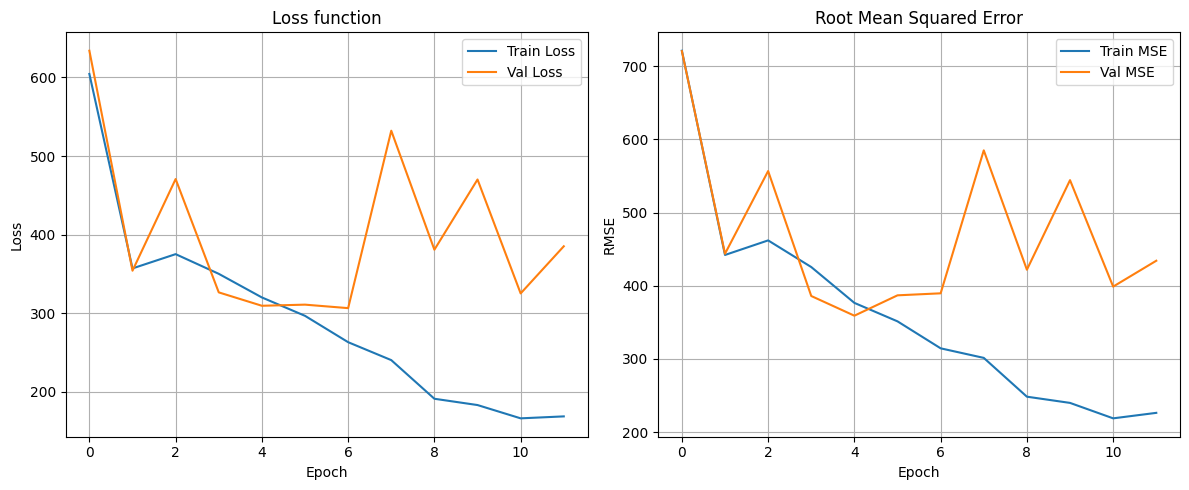

In [23]:
plot_train(history_tr_1, history_va_1, "metrics_training_1.png")

In [24]:
# Загружаем лучшие веса модели
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = PointNetMasked(in_channels=3, dropout=0.2).to(device)
# model.load_state_dict(torch.load("checkpoints/best_model_2.pt", map_location=device, weights_only=True))
# model.eval()
# print("Loaded best model for evaluation.")

In [25]:
predict_model(model_1, test_loader)

TEST | MAE=281.775 MSE=107920.961 RMSE=328.513 R2=0.2749


In [26]:
model = PointNetMasked(in_channels=3, dropout=0.2)
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = HuberRel(delta=1.0, alpha=0.1)
early_stopping = EarlyStopping(patience=10, min_delta=0.001, save_path="best_model_2_states.pt")
model_2, history_tr_2, history_va_2 = train_model(model, optimizer, criterion, early_stopping, 15, "best_model_2.pt")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 | train: loss=609.664, mae=610.073, rmse=722.488 | val:   loss=654.453, mae=654.858, rmse=738.683
  ✅ Saved new best model to checkpoints/best_model_2_states.pt
Epoch 02 | train: loss=405.754, mae=406.197, rmse=530.960 | val:   loss=545.267, mae=545.694, rmse=646.944
  ✅ Saved new best model to checkpoints/best_model_2_states.pt
Epoch 03 | train: loss=359.719, mae=360.153, rmse=433.717 | val:   loss=349.907, mae=350.360, rmse=447.545
  ✅ Saved new best model to checkpoints/best_model_2_states.pt
Epoch 04 | train: loss=351.875, mae=352.319, rmse=431.157 | val:   loss=376.403, mae=376.854, rmse=468.114
  No improvement (1/10)
Epoch 05 | train: loss=340.418, mae=340.863, rmse=419.961 | val:   loss=362.678, mae=363.125, rmse=426.166
  No improvement (2/10)
Epoch 06 | train: loss=335.132, mae=335.564, rmse=379.375 | val:   loss=393.345, mae=393.792, rmse=508.405
  No improvement (3/10)
Epoch 07 | train: loss=317.980, mae=318.408, rmse=354.018 | val:   loss=319.388, mae=319.844, rms

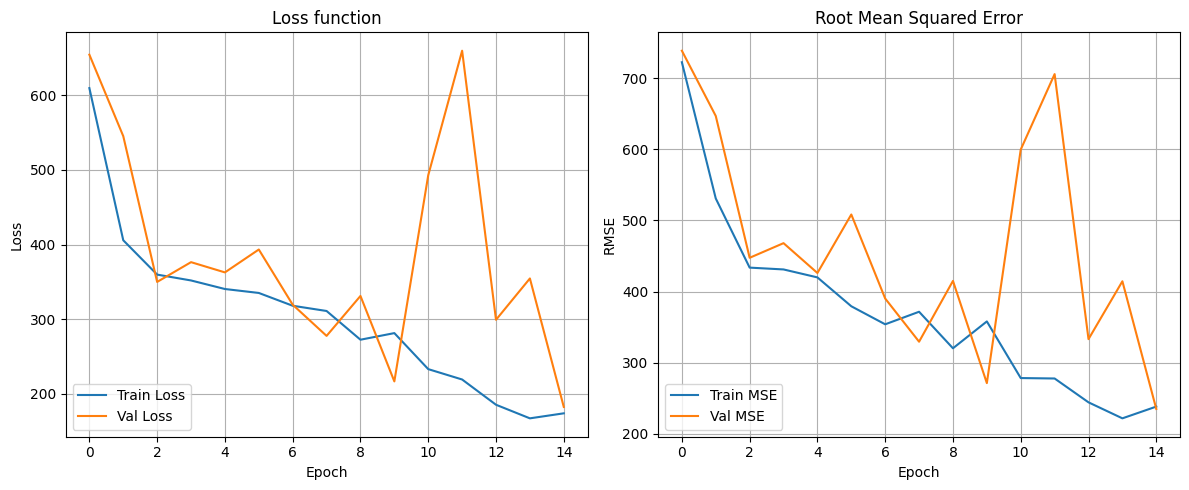

In [27]:
plot_train(history_tr_2, history_va_2, "metrics_training_2.png")

In [28]:
predict_model(model_2, test_loader)

TEST | MAE=174.596 MSE=44193.230 RMSE=210.222 R2=0.7031
